<font color=#0C2C76 ><font>
<p style = "font-family:georgia;">
    <font size="6">
        Toy Dataset & Box Dataset<br><font size="5"> 
    </font>    
</p>

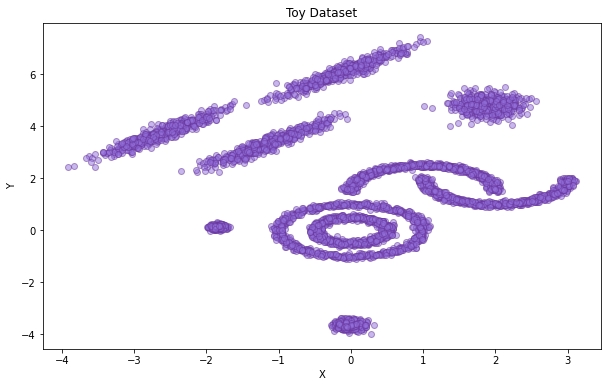

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cluster import AffinityPropagation


toy_data = pd.read_csv (r'ToyDataSet.csv').to_numpy() 
data_size = len(toy_data)

plt.figure(figsize=(10, 6))
plt.scatter(toy_data[:,0], toy_data[:,1], color = 'mediumpurple' ,  alpha = 0.5, edgecolors = 'rebeccapurple')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Toy Dataset')
plt.show()

## Sampling Toy Dataset

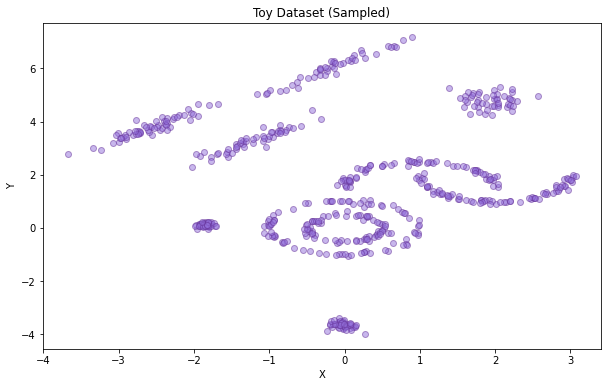

In [4]:
np.random.shuffle(toy_data)
toy_samples = toy_data[:600]

plt.figure(figsize=(10, 6))
plt.scatter(toy_samples[:,0], toy_samples[:,1], color = 'mediumpurple' ,  alpha = 0.5, edgecolors = 'rebeccapurple')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Toy Dataset (Sampled)')
plt.show()

In [5]:
bboxes_data_set = pd.read_csv('bboxes.csv').to_numpy()
norm_bboxes = np.zeros((bboxes_data_set.shape[0], 2))
norm_bboxes[:, 0] = (bboxes_data_set[:, 4] - bboxes_data_set[:, 2]) / bboxes_data_set[:, 0]
norm_bboxes[:, 1] = (bboxes_data_set[:, 5] - bboxes_data_set[:, 3]) / bboxes_data_set[:, 1]

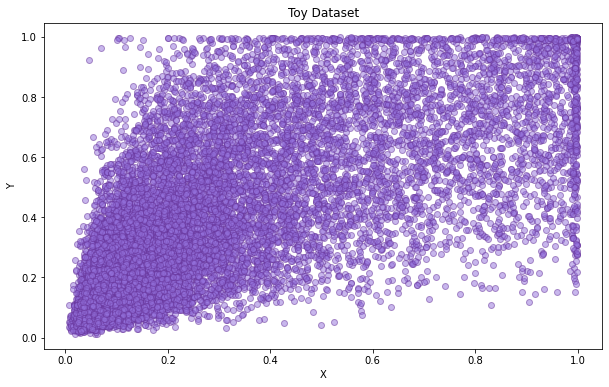

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(norm_bboxes[:,0], norm_bboxes[:,1], color = 'mediumpurple' , alpha = 0.5, edgecolors = 'rebeccapurple')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Toy Dataset')
plt.show()

<font color=#0C2C76 ><font>
<p style = "font-family:georgia;">
    <font size="6">
        Affinity Propagation<br><font size="5"> 
    </font>    
</p>

<p style = "font-family:georgia;">
    <b><font size="4"> <font color="#D6274F" >  A) Affinity propagation from scratch : </b><font></font>
    </font>    
</p>

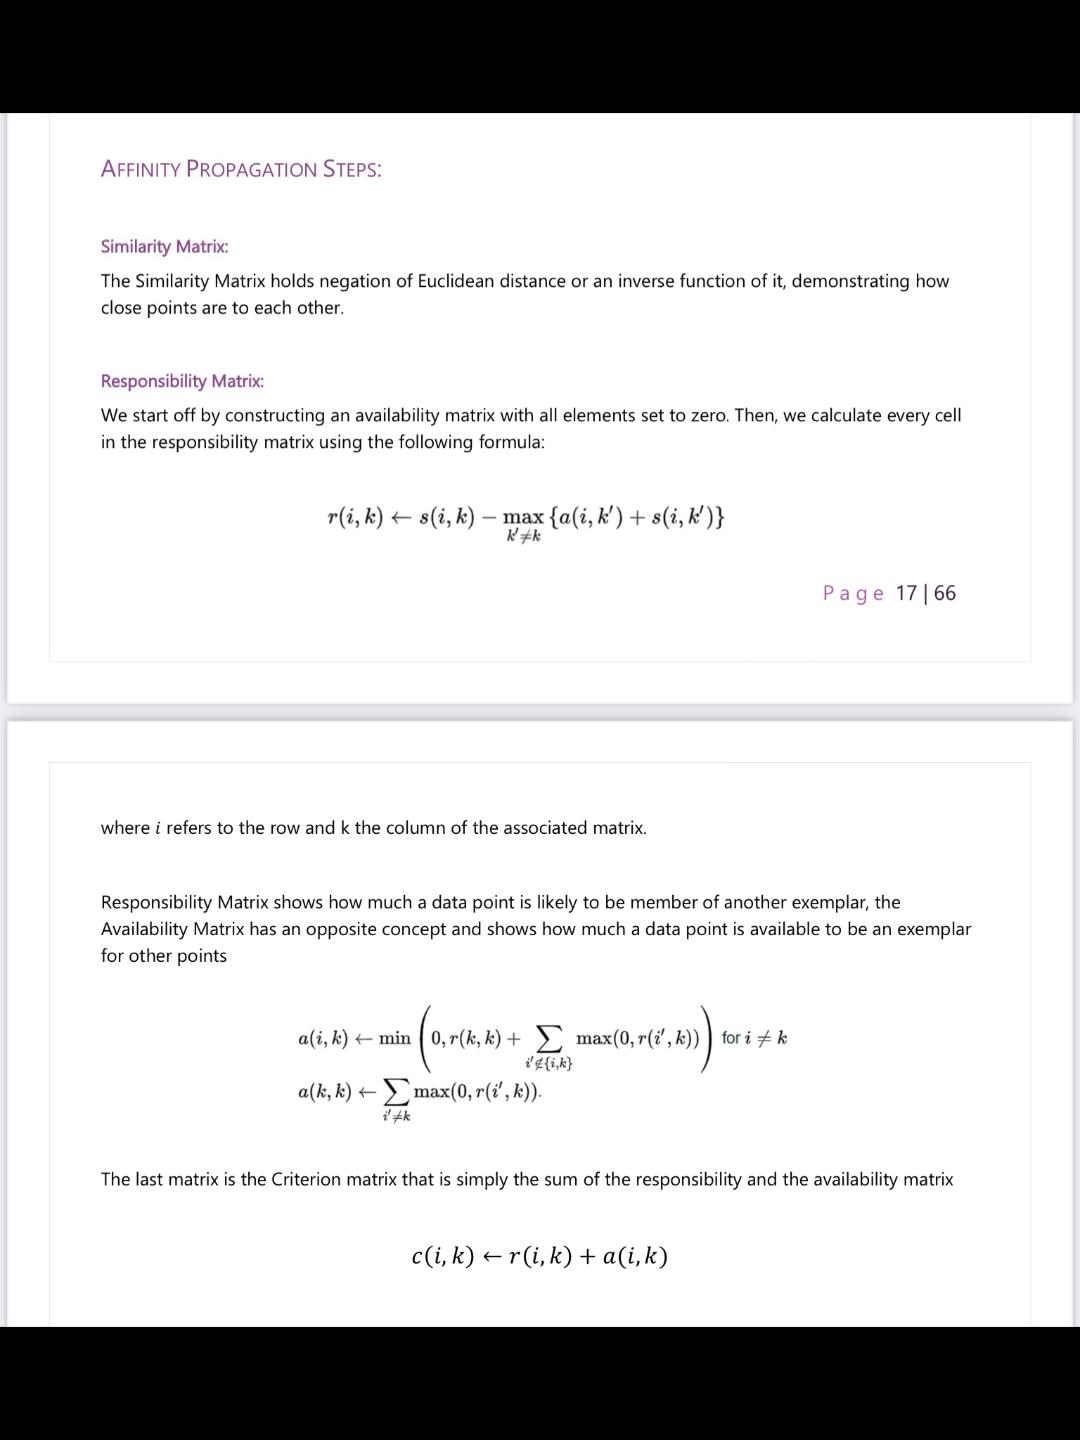

In [10]:
def distance(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    dist = np.sqrt(np.sum((x1-x2)**2))
    return dist

In [58]:
def affinity_propagation(data, distance_file = None, output_file = None,
                         damping_flag = False, damping_factor = 1,
                        preference = 'Min', iteration_lim = 10):
    
    similarity  = np.zeros((data_size, data_size))
    
    responsability  = np.zeros((data_size, data_size))
    new_responsability  = np.zeros((data_size, data_size))
    
    availability  = np.zeros((data_size, data_size))
    new_availability  = np.zeros((data_size, data_size))

    criterion  = np.zeros((data_size, data_size))
    exemplar = np.zeros((data_size))
    cluster_index = np.zeros((data_size))
    new_cluster_index = np.ones((data_size))

    iteration = 0
    
    # Iterating over updates:
    while((np.ndarray.all(cluster_index != new_cluster_index)) and (iteration < iteration_lim)):
        cluster_index = new_cluster_index

        # PART 1: Similarity Matrix:


        if(distance_file == None):
            dist = np.zeros((data_size, data_size)) 

            for i in range(len(toy_data)):
                for j in range(len(toy_data)):       

                    dist[i][j] = distance(toy_data[i], toy_data[j]) # Pairwise Distance Calculation
                    #np.savetxt("Affinity_Distance.csv",dist , delimiter=",")

        else:
            dist = pd.read_csv ((distance_file + '.csv'), header =  None).to_numpy()  # Loading data in 'load_dist' mode

        similarity = -dist

        if(preference == 'max'):
                similarity += np.eye(data_size) * (np.amax(similarity[np.nonzero(similarity)])) # Diagonal values Initialization: median of non-diagonal values

        elif(preference == 'med'):
                similarity += np.eye(data_size) * (np.median(similarity[np.nonzero(similarity)])) # Diagonal values Initialization: median of non-diagonal values

        else:
            similarity += np.eye(data_size) * (np.amin(similarity[np.nonzero(similarity)])) # Diagonal values Initialization: median of non-diagonal values

        # PART 2: Responsability Matrix:

        for i in range(data_size):
            for k in range(data_size):  

                new_responsability[i][k] = similarity[i][k] - np.ndarray.max(np.delete((availability[i] + similarity[i]), k, 0))


        # PART 3,4: Availability Matrix, Criterion Matrix, Examplar Identification, Cluster Assignment:

        for i in range(data_size):
            for k in range(data_size):

                availability[k][k] = np.sum(np.maximum(np.delete((responsability[:,k]), k, 0), np.zeros((data_size-1))))
                availability[i][k] = min(0, responsability[k][k] + np.sum(np.maximum(np.delete((responsability[:,k]), k, 0), np.zeros((data_size-1)))))


                # ADDED‌PART:‌DAMPING‌FACTOR‌:

                if((damping_flag == True) and (damping_factor >= 0.5) and (damping_factor<=1)):
                    responsability[i][k] = new_responsability[i][k]*(1 - damping_factor) + responsability[i][k]*(damping_factor)
                    availability[i][k] = new_availability[i][k]*(1 - damping_factor) + availability[i][k]*(damping_factor)
                else:
                    responsability = new_responsability
                    availability = new_availability


                criterion[i][k] = responsability[i][k] + availability[i][k]

            exemplar[i] = np.argmax(criterion[i])
            cluster_index[i] = np.where(exemplar[i] == np.unique(exemplar[i]))[0][0] # Mapping unique exemplars to cluster index
            print(f"Iteration #{iteration} finished!\n\n{len(np.unique(cluster_index))} Clusters found!")
            iteration += 1
    
    if(output_file!=None): #Saves outputs of needed
        np.savetxt((output_file + '.csv'),cluster_index , delimiter=",")

    return cluster_index

In [ ]:
toy_cluster_indices = affinity_propagation(toy_data)

In [59]:
sample_toy_data = toy_data[0:100,:]
sample_toy_cluster_indices = affinity_propagation(sample_toy_data, output_file = 'Affinity Clusters',
                                                  damping_flag = True, damping_factor = 0.7)

print(f" Total Number of Clusters are: {len(np.unique(sample_toy_cluster_indices))}")

Iteration #0 finished!

2 Clusters found!
Iteration #1 finished!

2 Clusters found!
Iteration #2 finished!

2 Clusters found!
Iteration #3 finished!

2 Clusters found!
Iteration #4 finished!

2 Clusters found!
Iteration #5 finished!

2 Clusters found!
Iteration #6 finished!

2 Clusters found!
Iteration #7 finished!

2 Clusters found!
Iteration #8 finished!

2 Clusters found!
Iteration #9 finished!

2 Clusters found!
Iteration #10 finished!

2 Clusters found!
Iteration #11 finished!

2 Clusters found!
Iteration #12 finished!

2 Clusters found!
Iteration #13 finished!

2 Clusters found!
Iteration #14 finished!

2 Clusters found!
Iteration #15 finished!

2 Clusters found!
Iteration #16 finished!

2 Clusters found!
Iteration #17 finished!

2 Clusters found!
Iteration #18 finished!

2 Clusters found!
Iteration #19 finished!

2 Clusters found!
Iteration #20 finished!

2 Clusters found!
Iteration #21 finished!

2 Clusters found!
Iteration #22 finished!

2 Clusters found!
Iteration #23 finishe

Iteration #189 finished!

2 Clusters found!
Iteration #190 finished!

2 Clusters found!
Iteration #191 finished!

2 Clusters found!
Iteration #192 finished!

2 Clusters found!
Iteration #193 finished!

2 Clusters found!
Iteration #194 finished!

2 Clusters found!
Iteration #195 finished!

2 Clusters found!
Iteration #196 finished!

2 Clusters found!
Iteration #197 finished!

2 Clusters found!
Iteration #198 finished!

2 Clusters found!
Iteration #199 finished!

2 Clusters found!
Iteration #200 finished!

2 Clusters found!
Iteration #201 finished!

2 Clusters found!
Iteration #202 finished!

2 Clusters found!
Iteration #203 finished!

2 Clusters found!
Iteration #204 finished!

2 Clusters found!
Iteration #205 finished!

2 Clusters found!
Iteration #206 finished!

2 Clusters found!
Iteration #207 finished!

2 Clusters found!
Iteration #208 finished!

2 Clusters found!
Iteration #209 finished!

2 Clusters found!
Iteration #210 finished!

2 Clusters found!
Iteration #211 finished!

2 Clus

Iteration #376 finished!

2 Clusters found!
Iteration #377 finished!

2 Clusters found!
Iteration #378 finished!

2 Clusters found!
Iteration #379 finished!

2 Clusters found!
Iteration #380 finished!

2 Clusters found!
Iteration #381 finished!

2 Clusters found!
Iteration #382 finished!

2 Clusters found!
Iteration #383 finished!

2 Clusters found!
Iteration #384 finished!

2 Clusters found!
Iteration #385 finished!

2 Clusters found!
Iteration #386 finished!

2 Clusters found!
Iteration #387 finished!

2 Clusters found!
Iteration #388 finished!

2 Clusters found!
Iteration #389 finished!

2 Clusters found!
Iteration #390 finished!

2 Clusters found!
Iteration #391 finished!

2 Clusters found!
Iteration #392 finished!

2 Clusters found!
Iteration #393 finished!

2 Clusters found!
Iteration #394 finished!

2 Clusters found!
Iteration #395 finished!

2 Clusters found!
Iteration #396 finished!

2 Clusters found!
Iteration #397 finished!

2 Clusters found!
Iteration #398 finished!

2 Clus

Iteration #563 finished!

2 Clusters found!
Iteration #564 finished!

2 Clusters found!
Iteration #565 finished!

2 Clusters found!
Iteration #566 finished!

2 Clusters found!
Iteration #567 finished!

2 Clusters found!
Iteration #568 finished!

2 Clusters found!
Iteration #569 finished!

2 Clusters found!
Iteration #570 finished!

2 Clusters found!
Iteration #571 finished!

2 Clusters found!
Iteration #572 finished!

2 Clusters found!
Iteration #573 finished!

2 Clusters found!
Iteration #574 finished!

2 Clusters found!
Iteration #575 finished!

2 Clusters found!
Iteration #576 finished!

2 Clusters found!
Iteration #577 finished!

2 Clusters found!
Iteration #578 finished!

2 Clusters found!
Iteration #579 finished!

2 Clusters found!
Iteration #580 finished!

2 Clusters found!
Iteration #581 finished!

2 Clusters found!
Iteration #582 finished!

2 Clusters found!
Iteration #583 finished!

2 Clusters found!
Iteration #584 finished!

2 Clusters found!
Iteration #585 finished!

2 Clus

Iteration #750 finished!

2 Clusters found!
Iteration #751 finished!

2 Clusters found!
Iteration #752 finished!

2 Clusters found!
Iteration #753 finished!

2 Clusters found!
Iteration #754 finished!

2 Clusters found!
Iteration #755 finished!

2 Clusters found!
Iteration #756 finished!

2 Clusters found!
Iteration #757 finished!

2 Clusters found!
Iteration #758 finished!

2 Clusters found!
Iteration #759 finished!

2 Clusters found!
Iteration #760 finished!

2 Clusters found!
Iteration #761 finished!

2 Clusters found!
Iteration #762 finished!

2 Clusters found!
Iteration #763 finished!

2 Clusters found!
Iteration #764 finished!

2 Clusters found!
Iteration #765 finished!

2 Clusters found!
Iteration #766 finished!

2 Clusters found!
Iteration #767 finished!

2 Clusters found!
Iteration #768 finished!

2 Clusters found!
Iteration #769 finished!

2 Clusters found!
Iteration #770 finished!

2 Clusters found!
Iteration #771 finished!

2 Clusters found!
Iteration #772 finished!

2 Clus

KeyboardInterrupt: 

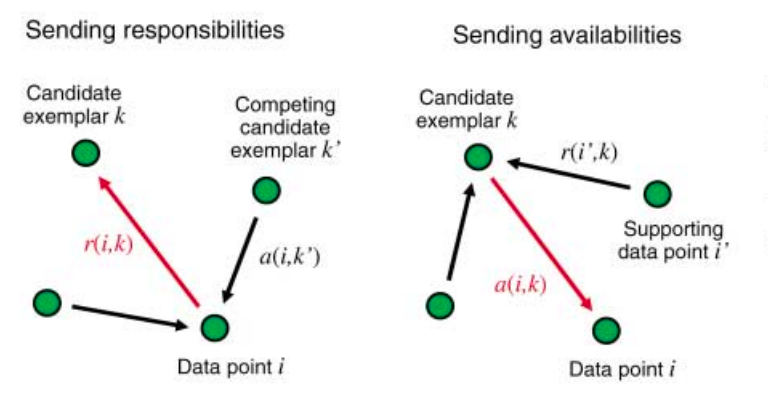

<p style = "font-family:georgia;">
    <b><font size="4"> <font color="#D6274F" >  A) Initial Preference Effect : </b><font></font>
    </font>    
</p>

    
<p style = "font-family:cambria;">
    <font size="3"> <font color="#00000" >  <b> Prefernece of a data point being an exemplar</b>  is embedded in the <b>‌diagonal values of the similarity and has a large effect on the algorithms results</b> , This preference values <b> can be fed using a'priori information of another algorithm</b>. <br><br>If <b> no Prior knowledge</b>  is provided these diagonal values can <b> aqquire 3 different common values</b>:<br><br> 1. <b> Min of Non-Diagonal Values </b> (Resulting in Min clusters) <br>2. <b> Max of Diagonal Values </b> (Resulting in Max Clusters) </b><br>3. <b> Median of Non-Diagonal values</b> (Resulting in Medium number of clusters) <font></font>
    </font>    
</p>

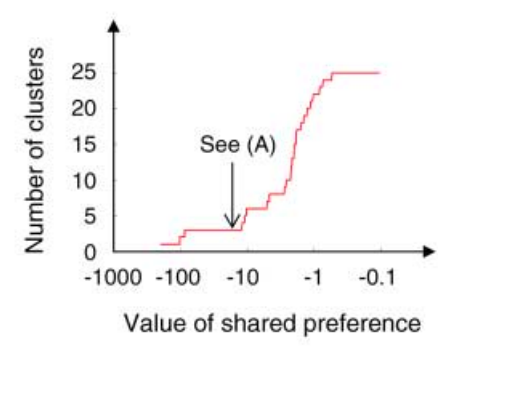

<p style = "font-family:georgia;">
    <b><font size="4"> <font color="#D6274F" >  B) Damping Factor Effect Demonstration (The inertia effect) : </b><font></font>
    </font>    
</p>
    

<p style = "font-family:cambria;">
    <font size="3"> <font color="#00000" > Damping factor <b> act like learning rates.</b> <br>They are the <b> tools to control</b> the <b> convergence </b> of our algorithm based on a <b> balance</b>  between <b> reliability to temporal information</b>  and <b> accumulated information</b> till now. <br><br> The <b> difference</b> however is that learning rates, <b> weight gradient information of a cost function against previous cost values (step size)</b> , but AP's <b> damping factor weights temporal and past information against eachother</b> in terms of info-based matrices </b>
    </font>    
</p>



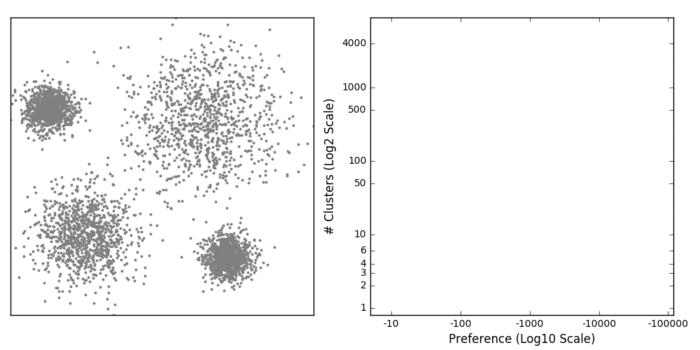

<p style = "font-family:cambria;">
    <font size="3"> <font color="#00000" > Damping factors <b> become much more important when no a'priori estimation is provided for Datapoint Preferences</b>. This prior information <b> can be fed using other alogorithms output information </b>.<br><br>Damping Factors are actually making a<b>  Trade-off</b> between:<br><br>1. <b> Avoiding Numerical Oscillations</b>  caused by temporal information appeared in messages and <b> Increasing convergence Probability sometimes</b> <br>2. <b> Decreasing Convergence Rate</b> by less reliance on Temporal Info
    </font>    
</p>



<p style = "font-family:georgia;">
    <b><font size="4"> <font color="#D6274F" >  C) Adv & DisAdv : </b><font></font>
    </font>    
</p>
    

<p style = "font-family:camria;">
    <font size="4"> <font color="#00000" > Adavantages :<br><br>  1. No need to initialize number of clusters (Set preference instead)<br> 2. Dealing with similarity matrix instead of raw data <br><br><br>Dis-advantages :<br><br>1. Good results need good damping factors and good damping factor estimators <br> 2. Very high time and Copuational Complexity </b><font></fonta
    </font> 
</p>
    